# Portfolio Optimizer
#### Trading CFDs i would like to create a portfolio that has a maximum drawdown limited to the margin call limit from the CFD broker. Trade indices and commodities and use fx to hedge currency movements. 

In [1]:
pip install MetaTrader5


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [56]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz
pd.set_option('display.max_columns', 500) # number of columns to be displayed
pd.set_option('display.width', 1500)      # max table width to display
pd.set_option('display.max_rows', 5000)
import hvplot.pandas
import pypfopt
import matplotlib.pyplot as plt
from pypfopt.expected_returns import mean_historical_return
from pypfopt import plotting, base_optimizer, risk_models, expected_returns, EfficientSemivariance, objective_functions
from pypfopt.risk_models import risk_matrix
from pypfopt.efficient_frontier import EfficientFrontier, EfficientCDaR
import seaborn as sns
import scipy.optimize as sco
import requests
from pathlib import Path
from dotenv import load_dotenv
import os
import platform
from pypfopt.plotting import plot_weights

print(platform.python_version())

3.7.13


In [57]:
# !pip list

## Connect to Metatrader and obtain account details

In [58]:
# Load variables from the .env file
load_dotenv("aaa.env")
# Access the variables
login = int(os.getenv("LOGIN"))
password = os.getenv("PASSWORD")
server = os.getenv("SERVER")
path_1_mt = os.getenv("path_1_mt")

In [59]:
#ThinkMarkets account
timeout = 10000
portable = False

if mt5.initialize(path=path_1_mt, login=login, password=password, server=server, timeout=timeout, portable=portable):
    print("Initialization successful")
    

Initialization successful


In [141]:
# Get account info
account_info_dict = mt5.account_info()._asdict()
account_info_df = pd.DataFrame(account_info_dict, index=[0])
account_info_df

login  trade_mode  leverage  limit_orders  margin_so_mode  trade_allowed  trade_expert  margin_mode  currency_digits  fifo_close    balance  credit   profit     equity    margin  margin_free  margin_level  margin_so_call  margin_so_so  margin_initial  margin_maintenance  assets  liabilities  commission_blocked                       name             server currency                           company
0  59841           0        30           100               0           True          True            2                2       False 99596.7200  0.0000 -17.5900 99579.1300 2634.5300   96944.6000     3779.7683        100.0000       50.0000          0.0000              0.0000  0.0000       0.0000              0.0000  Joshua Luke Tenison Woods  ThinkMarkets-Demo      AUD  TF Global Markets (Aust) Pty Ltd

In [61]:
# display relevant information
print("Profit:", account_info_df["profit"].loc[0])
print("Equity:", account_info_df["equity"].loc[0])
print("Margin:", account_info_df["margin"].loc[0])
print("Margin Free:", account_info_df["margin_free"].loc[0])

Profit: 0.0
Equity: 99667.7
Margin: 0.0
Margin Free: 99667.7


## Retrieve ticker data from Metatrader and concatenate into dataframe for PyportfolioOpt analyse

In [62]:
# Get bars function to recieve daily ticker data
def get_bars_data(symbol):

    # set time zone to UTC
    timezone = pytz.timezone("Etc/UTC")
    # create 'datetime' object in UTC time zone to avoid the implementation of a local time zone offset
    utc_from = datetime(2010, 11, 1, tzinfo=timezone)
    utc_to = datetime(2023, 11, 1, tzinfo=timezone)
    # get 10 EURUSD H4 bars starting from 01.10.2020 in UTC time zone
    rates = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_D1, utc_from, utc_to)
    # create DataFrame out of the obtained data
    rates_frame = pd.DataFrame(rates)
    # convert time in seconds into the datetime format
    rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
    #Set index to time
    rates_frame = rates_frame.set_index('time')
    # Remove unwanted columns
    rates_frame = rates_frame['close']
    # Change series into df
    rates_frame = pd.DataFrame(rates_frame)
    #Rename column to symbol
    rates_frame = rates_frame.rename(columns={'close':symbol})
    return rates_frame
    
    

In [63]:
EURUSDx = get_bars_data('EURUSDx')
AUDUSDx = get_bars_data('AUDUSDx')
GBPUSDx = get_bars_data('GBPUSDx')
USDJPYx = get_bars_data('USDJPYx')
USDCHFx = get_bars_data('USDCHFx')
XAUUSDx = get_bars_data('XAUUSDx')
XAUEURx = get_bars_data('XAUEURx')
XAGUSDx = get_bars_data('XAGUSDx')
GBPAUDx = get_bars_data('GBPAUDx')
EURAUDx = get_bars_data('EURAUDx')
AUDJPYx = get_bars_data('AUDJPYx')
BRENT = get_bars_data('BRENT')
NGAS = get_bars_data('NGAS')
COPPER = get_bars_data('COPPER')
WTI = get_bars_data('WTI')
BRENT = get_bars_data('BRENT')
WHEAT = get_bars_data('WHEAT')
CORN = get_bars_data('CORN')
SOYBEANS = get_bars_data('SOYBEANS')
ESTX50 = get_bars_data('ESTX50')
FRA40 = get_bars_data('FRA40')
GER40 = get_bars_data('GER40')
AUS200 = get_bars_data('AUS200')
UK100 = get_bars_data('UK100')
US30 = get_bars_data('US30')
JPN225 = get_bars_data('JPN225')
NAS100 = get_bars_data('NAS100')
SPX500 = get_bars_data('SPX500')
US2000 = get_bars_data('US2000')
ETHUSD = get_bars_data('ETHUSD')
BTCUSD = get_bars_data('BTCUSD')

In [64]:
# Concatenate dataframes
df = pd.concat([XAUUSDx, XAGUSDx,   
                ESTX50, FRA40, GER40, AUS200, UK100, US30, JPN225, NAS100, SPX500, US2000,
                WTI, AUDUSDx, EURAUDx, GBPAUDx, AUDJPYx   # Added currencies may need to remove, dont think currency for growth is good because past performance is not indicitave of future performance. 
               ], join='outer', axis=1)
df = df.dropna()
display(df.head(3))
display(df.tail(3))

# deleted these as they had the most nans SOYBEANS, XAUEURx,COPPER, NGAS, WHEAT, CORN, ETHUSD, BTCUSD, AUDUSDx, GBPAUDx, EURAUDx
# removed fx to check returns without them GBPUSDx, AUDUSDx, USDCHFx,EURUSDx,USDJPYx

XAUUSDx  XAGUSDx  ESTX50   FRA40   GER40  AUS200   UK100     US30  JPN225  NAS100  SPX500  US2000    WTI  AUDUSDx  EURAUDx  GBPAUDx  AUDJPYx
time                                                                                                                                                    
2012-08-30  1655.18    30.43  2413.0  3380.0  6900.0  4301.0  5716.0  12986.0  8910.0  2752.0  1397.9   807.1  94.55  1.02925  1.21454  1.53430   80.906
2012-08-31  1690.81    31.64  2438.0  3400.0  6957.0  4339.0  5710.0  13092.0  8880.0  2771.0  1407.4   807.5  96.59  1.03192  1.21793  1.53570   80.883
2012-09-03  1692.42    32.08  2464.0  3453.0  7011.0  4335.0  5754.0  13093.0  8790.0  2776.0  1408.1   817.0  96.83  1.02421  1.22843  1.54962   80.176

XAUUSDx  XAGUSDx   ESTX50   FRA40     GER40   AUS200    UK100      US30    JPN225    NAS100   SPX500   US2000    WTI  AUDUSDx  EURAUDx  GBPAUDx  AUDJPYx
time                                                                                                                                                                
2023-10-30  1996.23   23.305  4040.00  6847.2  14764.50  6803.05  7337.40  32927.73  30564.00  14332.07  4169.86  1643.24  82.26  0.63740  1.66474  1.90863   95.012
2023-10-31  1983.92   22.835  4069.03  6901.0  14850.50  6809.50  7331.95  32997.84  31358.20  14375.44  4189.45  1656.04  81.15  0.63369  1.66847  1.91731   96.046
2023-11-01  1982.69   22.931  4110.00  6965.3  14993.98  6886.62  7370.90  33276.45  31899.55  14682.55  4245.10  1667.01  80.70  0.63930  1.65302  1.90023   96.510

### Convert prices into AUD to give real returns for optimiser. Also add AUDUSD, EURUSD, AUDJPY, GBPAUD for currency conversions and to allow hedging 

In [65]:
# df.to_csv('project_data.csv')

In [66]:
df.isna().sum()

XAUUSDx    0
XAGUSDx    0
ESTX50     0
FRA40      0
GER40      0
AUS200     0
UK100      0
US30       0
JPN225     0
NAS100     0
SPX500     0
US2000     0
WTI        0
AUDUSDx    0
EURAUDx    0
GBPAUDx    0
AUDJPYx    0
dtype: int64

## Covert prices to AUD for realistic returns in the optimiser

In [67]:
# Function to perform multiple calculations and return a Series with results
def multiple_calculations(row):
    result = pd.Series(dtype=float)
    result['XAUUSDx'] = float(row['XAUUSDx'] * (1 / row['AUDUSDx']))
    result['XAGUSDx'] = float(row['XAGUSDx'] * (1 / row['AUDUSDx']))
    result['ESTX50'] = float(row['ESTX50'] * row['EURAUDx'])
    result['FRA40'] = float(row['FRA40'] * row['EURAUDx'])
    result['GER40'] = float(row['GER40'] * row['EURAUDx'])
    result['UK100'] = float(row['UK100'] * row['EURAUDx'])
    result['US30'] = float(row['US30'] * (1 / row['AUDUSDx']))
    result['JPN225'] = float(row['JPN225'] * (1 / row['AUDJPYx']))
    result['NAS100'] = float(row['NAS100'] * (1 / row['AUDUSDx']))
    result['SPX500'] = float(row['SPX500'] * (1 / row['AUDUSDx']))
    result['US2000'] = float(row['US2000'] * (1 / row['AUDUSDx']))
    result['WTI'] = float(row['WTI'] * (1 / row['AUDUSDx']))     

    return result

# Apply the function to create multiple new columns
df_aud = df.apply(multiple_calculations, axis=1)

df_aud

XAUUSDx    XAGUSDx       ESTX50         FRA40         GER40         UK100          US30      JPN225        NAS100       SPX500       US2000         WTI
time                                                                                                                                                                   
2012-08-30  1608.141851  29.565217  2930.685020   4105.145200   8380.326000   6942.310640  12616.954093  110.127803   2673.791596  1358.173427   784.163226   91.863007
2012-08-31  1638.508799  30.661292  2969.313340   4140.962000   8473.139010   6954.380300  12687.030002  109.788213   2685.285681  1363.865416   782.521901   93.602217
2012-09-03  1652.415032  31.321702  3026.851520   4241.768790   8612.522730   7068.386220  12783.511194  109.633806   2710.381660  1374.815712   797.687974   94.541159
2012-09-04  1658.460004  31.603967  3004.122600   4189.798800   8545.469400   6982.588440  12747.226950  109.356681   2708.492282  1373.417845   804.429055   93.276209
2012-09-05  1660.626337  31.620980  3010.652400   4205.767700   8604.335800   6992.722200  12809.293017  108.733198   2715.695701  1378.451033   807.252320   93.940702
2012-09-06  1653.387539  31.725962  3101.053500   4308.315120   8794.710540   7094.964780  12919.916746  109.273443   2747.573382  1393.141279   814.837869   92.201755
2012-09-07  1671.380134  32.413116  3132.709000   4342.625350   8908.487050   7144.796550  12810.164137  109.033808   2719.234029  1386.009864   806.812052   92.760268
2012-09-10  1670.244167  32.255567  3102.627960   4308.382740   8872.232460   7120.987800  12804.482682  108.924972   2694.254386  1380.611820   810.502173   93.127909
2012-09-11  1660.727130  32.088844  3146.298140   4351.106120   8990.479180   7129.063170  12754.979717  108.611231   2665.119446  1371.975487   805.481764   92.881187
2012-09-12  1654.026669  31.716293  3153.660420   4365.089960   9041.972060   7125.621160  12763.943985  109.923852   2669.789227  1375.137409   809.061798   92.654017
2012-09-13  1675.420626  32.843946  3171.365120   4361.858160   9090.590080   7236.523360  12838.824712  110.791455   2684.990231  1384.320643   812.230885   93.068913
2012-09-14  1677.948105  32.820454  3212.993700   4443.210800   9189.933200   7339.010000  12880.748557  111.758942   2707.545292  1389.892210   813.401212   93.844506
2012-09-17  1681.631951  32.633298  3227.243520   4439.024640   9248.593920   7349.552640  12935.850786  111.065275   2724.694152  1395.677544   821.228357   92.589940
2012-09-18  1694.560309  33.282948  3183.390320   4384.646150   9174.700550   7321.049290  12990.777591  111.335123   2735.152304  1397.807286   821.693709   91.554416
2012-09-19  1689.906049  33.016346  3193.707150   4395.238300   9188.911800   7336.188120  12953.521234  111.849000   2730.675222  1393.408188   816.529178   88.011763
2012-09-20  1695.619654  33.216984  3171.319360   4369.262880   9184.647880   7282.104800  13038.433508  111.653163   2743.469756  1401.365502   819.588815   88.987764
2012-09-21  1695.389382  32.908390  3188.676100   4369.851060   9233.512660   7247.103930  12979.734705  111.200852   2734.236776  1394.948500   818.932127   89.037231
2012-09-24  1691.789034  32.552296  3173.657600   4343.943840   9197.408490   7243.625530  13011.327125  111.335633   2728.676520  1399.441796   818.315222   88.286353
2012-09-25  1695.124652  32.479851  3149.889520   4313.709110   9127.972430   7215.184630  12980.384982  111.287148   2705.851766  1390.865584   810.118537   87.434641
2012-09-26  1689.421111  32.704694  3100.559280   4243.262400   9032.441600   7152.750800  12956.535154  109.951866   2685.217324  1383.971615   803.251186   87.045393
2012-09-27  1701.204335  33.114421  3116.687600   4272.160600   9055.942400   7166.404200  12917.400628  110.664331   2700.658651  1386.325343   807.899977   88.266830
2012-09-28  1707.851092  33.112008  3043.461330   4158.282330   8965.638220   7117.512740  12947.990248  109.375580   2694.446318  1387.794043   813.152

In [68]:
df_forex = df[['AUDUSDx', 'EURAUDx', 'GBPAUDx', 'AUDJPYx']]
df_forex

AUDUSDx  EURAUDx  GBPAUDx  AUDJPYx
time                                          
2012-08-30  1.02925  1.21454  1.53430   80.906
2012-08-31  1.03192  1.21793  1.53570   80.883
2012-09-03  1.02421  1.22843  1.54962   80.176
2012-09-04  1.02234  1.22868  1.55203   80.178
2012-09-05  1.01926  1.23590  1.55979   79.902
2012-09-06  1.02818  1.22814  1.54937   81.081
2012-09-07  1.03816  1.23335  1.54060   81.195
2012-09-10  1.03331  1.23414  1.54677   80.863
2012-09-11  1.04273  1.23191  1.53984   81.115
2012-09-12  1.04615  1.23238  1.53835   81.420
2012-09-13  1.05438  1.23112  1.53174   81.685
2012-09-14  1.05483  1.24390  1.53578   82.669
2012-09-17  1.04709  1.25184  1.55081   82.420
2012-09-18  1.04528  1.24741  1.55341   82.337
2012-09-19  1.04736  1.24511  1.54754   82.066
2012-09-20  1.04284  1.24268  1.55362   81.583
2012-09-21  1.04563  1.24073  1.55079   81.717
2012-09-24  1.04263  1.23971  1.55580   81.160
2012-09-25  1.03849  1.24207  1.55754   80.791
2012-09-26  1.03716  1.24072  1.55857   80.608
2012-09-27  1.04456  1.23580  1.55451   81.074
2012-09-28  1.03769  1.23869  1.55654   80.859
2012-10-01  1.03554  1.24391  1.55631   80.763
2012-10-02  1.02616  1.25819  1.57149   80.207
2012-10-03  1.02188  1.26278  1.57283   80.196
2012-10-04  1.02438  1.27014  1.58065   80.388
2012-10-05  1.01854  1.27931  1.58300   80.113
2012-10-08  1.01911  1.27181  1.57197   79.792
2012-10-09  1.02075  1.26172  1.56800   79.873
2012-10-10  1.02190  1.25706  1.56376   79.850
2012-10-11  1.02639  1.25923  1.56291   80.462
2012-10-12  1.02318  1.26512  1.56990   80.238
2012-10-15  1.02511  1.26241  1.56709   80.662
2012-10-16  1.03022  1.27082  1.56803   81.234
2012-10-17  1.03728  1.26392  1.55510   81.988
2012-10-18  1.03669  1.26007  1.54758   82.187
2012-10-19  1.03267  1.25994  1.54760   81.872
2012-10-22  1.03267  1.26459  1.55093   82.533
2012-10-23  1.02647  1.26437  1.55378   81.972
2012-10-24  1.03475  1.25292  1.54866   82.563
2012-10-25  1.03550  1.24930  1.55746   83.196
2012-10-26  1.03712  1.24693  1.55161   82.587
2012-10-29  1.03255  1.24921  1.55099   82.361
2012-10-30  1.03690  1.25005  1.55101   82.526
2012-10-31  1.03691  1.24918  1.55418   82.750
2012-11-01  1.04128  1.24280  1.55002   83.464
2012-11-02  1.03351  1.24112  1.54854   83.092
2012-11-05  1.03712  1.23339  1.54129   83.191
2012-11-06  1.04276  1.22786  1.53356   83.814
2012-11-07  1.04026  1.22715  1.53488   83.153
2012-11-08  1.04000  1.22485  1.53553   82.649
2012-11-09  1.03849  1.22334  1.52975   82.514
2012-11-12  1.04256  1.21830  1.52229   82.926
2012-11-13  1.04311  1.21716  1.52059   82.844
2012-11-14  1.03616  1.22828  1.52642   83.059
2012-11-15  1.03297  1.23672  1.53501   83.794
2012-11-16  1.03379  1.23196  1.53531   84.048
2012-11-19  1.04091  1.22735  1.52740   84.622
2012-11-20  1.03832  1.23355  1.53263   84.789
2012-11-21  1.03656  1.23691  1.53816   85.528
2012-11-22  1.03840  1.23982  1.53361   85.610
2012-11-23  1.04586  1.23960  1.53130   86.155
2012-11-26  1.04658  1.24102  1.53164   85.865
2012-11-27  1.04432  1.23830  1.53332   85.718
2012-11-28  1.04770  1.23553  1.52829   85.989
2012-11-29  1.04295  1.24371  1.53705   85.643
2012-11-30  1.04257  1.24486  1.53484   85.977
2012-12-03  1.04218  1.25251  1.54395   85.635
2012-12-04  1.04657  1.25059  1.53697   85.695
2012-12-05  1.04512  1.25008  1.53863   86.135
2012-12-06  1.04698  1.23707  1.53045   86.273
2012-12-07  1.04847  1.23212  1.52848   86.473
2012-12-10  1.04849  1.23365  1.53237   86.330
2012-12-11  1.05348  1.23427  1.53017   86.939
2012-12-12  1.05485  1.23853  1.53005   87.738
2012-12-13  1.05243  1.24185  1.53023   87.993
2012-12-14  1.05651  1.24529  1.52973   88.209
2012-12-17  1.05447  1.24755  1.53510   88.434
2012-12-18  1.05173  1.25681  1.54253   88.620
2012-12-19  1.04747  1.25955  1.54983   88.055
2012-12-20  1.04762  1.26380  1.55261   88.356
2012-12-21  1.03965  1.26702  1.55345   87.601
2012-12-27  1.03638  1.27650  1.55099   89.387
2012-12-28  1.037

In [69]:
# Concatenate the new columns to the original DataFrame
df_aud_fx = pd.concat([df_forex, df_aud], axis=1)
df_aud_fx

AUDUSDx  EURAUDx  GBPAUDx  AUDJPYx      XAUUSDx    XAGUSDx       ESTX50         FRA40         GER40         UK100          US30      JPN225        NAS100       SPX500       US2000         WTI
time                                                                                                                                                                                                       
2012-08-30  1.02925  1.21454  1.53430   80.906  1608.141851  29.565217  2930.685020   4105.145200   8380.326000   6942.310640  12616.954093  110.127803   2673.791596  1358.173427   784.163226   91.863007
2012-08-31  1.03192  1.21793  1.53570   80.883  1638.508799  30.661292  2969.313340   4140.962000   8473.139010   6954.380300  12687.030002  109.788213   2685.285681  1363.865416   782.521901   93.602217
2012-09-03  1.02421  1.22843  1.54962   80.176  1652.415032  31.321702  3026.851520   4241.768790   8612.522730   7068.386220  12783.511194  109.633806   2710.381660  1374.815712   797.687974   94.541159
2012-09-04  1.02234  1.22868  1.55203   80.178  1658.460004  31.603967  3004.122600   4189.798800   8545.469400   6982.588440  12747.226950  109.356681   2708.492282  1373.417845   804.429055   93.276209
2012-09-05  1.01926  1.23590  1.55979   79.902  1660.626337  31.620980  3010.652400   4205.767700   8604.335800   6992.722200  12809.293017  108.733198   2715.695701  1378.451033   807.252320   93.940702
2012-09-06  1.02818  1.22814  1.54937   81.081  1653.387539  31.725962  3101.053500   4308.315120   8794.710540   7094.964780  12919.916746  109.273443   2747.573382  1393.141279   814.837869   92.201755
2012-09-07  1.03816  1.23335  1.54060   81.195  1671.380134  32.413116  3132.709000   4342.625350   8908.487050   7144.796550  12810.164137  109.033808   2719.234029  1386.009864   806.812052   92.760268
2012-09-10  1.03331  1.23414  1.54677   80.863  1670.244167  32.255567  3102.627960   4308.382740   8872.232460   7120.987800  12804.482682  108.924972   2694.254386  1380.611820   810.502173   93.127909
2012-09-11  1.04273  1.23191  1.53984   81.115  1660.727130  32.088844  3146.298140   4351.106120   8990.479180   7129.063170  12754.979717  108.611231   2665.119446  1371.975487   805.481764   92.881187
2012-09-12  1.04615  1.23238  1.53835   81.420  1654.026669  31.716293  3153.660420   4365.089960   9041.972060   7125.621160  12763.943985  109.923852   2669.789227  1375.137409   809.061798   92.654017
2012-09-13  1.05438  1.23112  1.53174   81.685  1675.420626  32.843946  3171.365120   4361.858160   9090.590080   7236.523360  12838.824712  110.791455   2684.990231  1384.320643   812.230885   93.068913
2012-09-14  1.05483  1.24390  1.53578   82.669  1677.948105  32.820454  3212.993700   4443.210800   9189.933200   7339.010000  12880.748557  111.758942   2707.545292  1389.892210   813.401212   93.844506
2012-09-17  1.04709  1.25184  1.55081   82.420  1681.631951  32.633298  3227.243520   4439.024640   9248.593920   7349.552640  12935.850786  111.065275   2724.694152  1395.677544   821.228357   92.589940
2012-09-18  1.04528  1.24741  1.55341   82.337  1694.560309  33.282948  3183.390320   4384.646150   9174.700550   7321.049290  12990.777591  111.335123   2735.152304  1397.807286   821.693709   91.554416
2012-09-19  1.04736  1.24511  1.54754   82.066  1689.906049  33.016346  3193.707150   4395.238300   9188.911800   7336.188120  12953.521234  111.849000   2730.675222  1393.408188   816.529178   88.011763
2012-09-20  1.04284  1.24268  1.55362   81.583  1695.619654  33.216984  3171.319360   4369.262880   9184.647880   7282.104800  13038.433508  111.653163   2743.469756  1401.365502   819.588815   88.987764
2012-09-21  1.04563  1.24073  1.55079   81.717  1695.389382  32.908390  3188.676100   4369.851060   9233.512660   7247.103930  12979.734705  111.200852   2734.236776  1394.948500   818.932127   89.037231
2012-09-24  1.04263  1.23971  1.55580   81.160  1691.789034  32.552296  3173.657600   4343.943840   9197.408490   7243.625530  13011.327

In [70]:
df_aud.isna().sum()

XAUUSDx    0
XAGUSDx    0
ESTX50     0
FRA40      0
GER40      0
UK100      0
US30       0
JPN225     0
NAS100     0
SPX500     0
US2000     0
WTI        0
dtype: int64

In [71]:
# df_aud.to_csv('project_data_aud.csv')

In [72]:
# Function to calculate average gain for each column
def calculate_average_gain(column):
    first_row = column.iloc[0]  # First row value
    last_row = column.iloc[-1]  # Last row value
    average_gain = ((last_row - first_row) / first_row) * 100
    return average_gain

# Loop through each column in the DataFrame
for col in df_aud_fx.columns:
    avg_gain = calculate_average_gain(df_aud_fx[col])
    print(f"Column '{col}': Average Gain = {avg_gain}")

    

Column 'AUDUSDx': Average Gain = -37.88681078455186
Column 'EURAUDx': Average Gain = 36.10255734681445
Column 'GBPAUDx': Average Gain = 23.849964153033962
Column 'AUDJPYx': Average Gain = 19.286579487306255
Column 'XAUUSDx': Average Gain = 92.85271505575885
Column 'XAGUSDx': Average Gain = 21.321344117186996
Column 'ESTX50': Average Gain = 131.8199381249098
Column 'FRA40': Average Gain = 180.47193570643984
Column 'GER40': Average Gain = 195.75638011695494
Column 'UK100': Average Gain = 75.50705737362397
Column 'US30': Average Gain = 312.55111133651997
Column 'JPN225': Average Gain = 200.13404893638716
Column 'NAS100': Average Gain = 758.9526623584935
Column 'SPX500': Average Gain = 388.90895447996473
Column 'US2000': Average Gain = 232.5270878740944
Column 'WTI': Average Gain = 37.41311123028122


In [73]:
#Calculate daily change stocks
combined_returns = df_aud_fx.pct_change()
combined_returns = combined_returns.dropna()

display(combined_returns)

AUDUSDx   EURAUDx   GBPAUDx   AUDJPYx   XAUUSDx   XAGUSDx    ESTX50     FRA40     GER40     UK100      US30        JPN225    NAS100    SPX500    US2000       WTI
time                                                                                                                                                                          
2012-08-31  0.002594  0.002791  0.000912 -0.000284  0.018883  0.037073  0.013181  0.008725  0.011075  0.001739  0.005554 -3.083599e-03  0.004299  0.004191 -0.002093  0.018933
2012-09-03 -0.007472  0.008621  0.009064 -0.008741  0.008487  0.021539  0.019378  0.024344  0.016450  0.016393  0.007605 -1.406408e-03  0.009346  0.008029  0.019381  0.010031
2012-09-04 -0.001826  0.000204  0.001555  0.000025  0.003658  0.009012 -0.007509 -0.012252 -0.007786 -0.012138 -0.002838 -2.527726e-03 -0.000697 -0.001017  0.008451 -0.013380
2012-09-05 -0.003013  0.005876  0.005000 -0.003442  0.001306  0.000538  0.002174  0.003811  0.006889  0.001451  0.004869 -5.701373e-03  0.002660  0.003665  0.003510  0.007124
2012-09-06  0.008751 -0.006279 -0.006680  0.014756 -0.004359  0.003320  0.030027  0.024383  0.022125  0.014621  0.008636  4.968533e-03  0.011738  0.010657  0.009397 -0.018511
2012-09-07  0.009706  0.004242 -0.005660  0.001406  0.010882  0.021659  0.010208  0.007964  0.012937  0.007024 -0.008495 -2.192986e-03 -0.010314 -0.005119 -0.009850  0.006058
2012-09-10 -0.004672  0.000641  0.004005 -0.004089 -0.000680 -0.004861 -0.009602 -0.007885 -0.004070 -0.003332 -0.000444 -9.981825e-04 -0.009186 -0.003895  0.004574  0.003963
2012-09-11  0.009116 -0.001807 -0.004480  0.003116 -0.005698 -0.005169  0.014075  0.009916  0.013328  0.001134 -0.003866 -2.880339e-03 -0.010814 -0.006255 -0.006194 -0.002649
2012-09-12  0.003280  0.000382 -0.000968  0.003760 -0.004035 -0.011610  0.002340  0.003214  0.005727 -0.000483  0.000703  1.208550e-02  0.001752  0.002305  0.004445 -0.002446
2012-09-13  0.007867 -0.001022 -0.004297  0.003255  0.012934  0.035554  0.005614 -0.000740  0.005377  0.015564  0.005867  7.892767e-03  0.005694  0.006678  0.003917  0.004478
2012-09-14  0.000427  0.010381  0.002638  0.012046  0.001509 -0.000715  0.013126  0.018651  0.010928  0.014162  0.003265  8.732508e-03  0.008400  0.004025  0.001441  0.008334
2012-09-17 -0.007338  0.006383  0.009787 -0.003012  0.002195 -0.005702  0.004435 -0.000942  0.006383  0.001437  0.004278 -6.206813e-03  0.006334  0.004162  0.009623 -0.013369
2012-09-18 -0.001729 -0.003539  0.001677 -0.001007  0.007688  0.019908 -0.013588 -0.012250 -0.007990 -0.003878  0.004246  2.429628e-03  0.003838  0.001526  0.000567 -0.011184
2012-09-19  0.001990 -0.001844 -0.003779 -0.003291 -0.002747 -0.008010  0.003241  0.002416  0.001549  0.002068 -0.002868  4.615586e-03 -0.001637 -0.003147 -0.006285 -0.038695
2012-09-20 -0.004316 -0.001952  0.003929 -0.005886  0.003381  0.006077 -0.007010 -0.005910 -0.000464 -0.007372  0.006555 -1.750901e-03  0.004685  0.005711  0.003747  0.011089
2012-09-21  0.002675 -0.001569 -0.001822  0.001642 -0.000136 -0.009290  0.005473  0.000135  0.005320 -0.004806 -0.004502 -4.051039e-03 -0.003365 -0.004579 -0.000801  0.000556
2012-09-24 -0.002869 -0.000822  0.003231 -0.006816 -0.002124 -0.010821 -0.004710 -0.005929 -0.003910 -0.000480  0.002434  1.212055e-03 -0.002034  0.003221 -0.000753 -0.008433
2012-09-25 -0.003971  0.001904  0.001118 -0.004547  0.001972 -0.002225 -0.007489 -0.006960 -0.007550 -0.003926 -0.002378 -4.354850e-04 -0.008365 -0.006128 -0.010017 -0.009647
2012-09-26 -0.001281 -0.001087  0.000661 -0.002265 -0.003365  0.006923 -0.015661 -0.016331 -0.010466 -0.008653 -0.001837 -1.199853e-02 -0.007626 -0.004957 -0.008477 -0.004452
2012-09-27  0.007135 -0.003965 -0.002605  0.005781  0.006975  0.012528  0.005202  0.006810  0.002602  0.001909 -0.003020  6.479795e-03  0.005750  0.001701  0.005787  0.014032
2012-09-28 -0.006577  0.002339  0.001306 -0.002652  0.003907 -0.000073 -0.023495 -0.026656 -0.009972 -0.006822  0.002368 -1.164559e-02 -0.002300  0.001059  0.00650

## Analyse data

In [74]:
# Plot returns to visualise data

cum_returns_index = (1 + combined_returns).cumprod(axis=0)
cum_returns_index

# Plot cumulative returns
cum_returns_index.hvplot(
    width=1500,
    height=900,
    rot=45
)

:NdOverlay   [Variable]
   :Curve   [time]   (value)

In [75]:
# Calculate the annualized `std`
portfolio_std = combined_returns.std() * np.sqrt(252)
#portfolio_std.plot(kind="bar", title="Sharpe Ratios")
portfolio_std.hvplot.bar( title="annualised standard deviation", rot=45)

:Bars   [index]   (0)

In [76]:
#Plot covariance
co_var = risk_models.risk_matrix(df_aud_fx, method='sample_cov')
co_var

AUDUSDx   EURAUDx   GBPAUDx   AUDJPYx   XAUUSDx   XAGUSDx    ESTX50     FRA40     GER40     UK100      US30    JPN225    NAS100    SPX500    US2000       WTI
AUDUSDx  0.010439 -0.006267 -0.005277  0.007950 -0.004825  0.001170  0.000420  0.000145  0.000206 -0.001172 -0.003580 -0.002540 -0.002489 -0.003117 -0.001644 -0.000757
EURAUDx -0.006267  0.008545  0.005626 -0.006517  0.004812  0.001538  0.001690  0.001933  0.001774  0.003202  0.000654  0.000384 -0.000056  0.000453 -0.000955 -0.001718
GBPAUDx -0.005277  0.005626  0.008953 -0.004923  0.003426  0.001291  0.002514  0.002551  0.002599  0.000937  0.002099  0.001794  0.001457  0.001963  0.001303  0.001404
AUDJPYx  0.007950 -0.006517 -0.004923  0.014064 -0.007872 -0.002310  0.006370  0.005976  0.005637  0.003405  0.002725  0.002553  0.003571  0.003035  0.005289  0.005694
XAUUSDx -0.004825  0.004812  0.003426 -0.007872  0.021007  0.024523 -0.003716 -0.003562 -0.003336 -0.001089 -0.001719 -0.001133 -0.001972 -0.001798 -0.003176  0.001536
XAGUSDx  0.001170  0.001538  0.001291 -0.002310  0.024523  0.058695  0.001691  0.001582  0.001946  0.002765 -0.000098  0.001010  0.001114  0.000301  0.001264  0.010648
ESTX50   0.000420  0.001690  0.002514  0.006370 -0.003716  0.001691  0.035375  0.033814  0.033355  0.024514  0.021303  0.018385  0.023686  0.021871  0.025054  0.014008
FRA40    0.000145  0.001933  0.002551  0.005976 -0.003562  0.001582  0.033814  0.034217  0.031663  0.024461  0.020753  0.017409  0.022035  0.020979  0.024293  0.014405
GER40    0.000206  0.001774  0.002599  0.005637 -0.003336  0.001946  0.033355  0.031663  0.034768  0.023519  0.020769  0.017623  0.023115  0.021099  0.024729  0.011699
UK100   -0.001172  0.003202  0.000937  0.003405 -0.001089  0.002765  0.024514  0.024461  0.023519  0.024681  0.017156  0.013476  0.017003  0.016847  0.019363  0.015220
US30    -0.003580  0.000654  0.002099  0.002725 -0.001719 -0.000098  0.021303  0.020753  0.020769  0.017156  0.024908  0.016199  0.024579  0.023782  0.025544  0.014997
JPN225  -0.002540  0.000384  0.001794  0.002553 -0.001133  0.001010  0.018385  0.017409  0.017623  0.013476  0.016199  0.025575  0.019176  0.016990  0.018694  0.009225
NAS100  -0.002489 -0.000056  0.001457  0.003571 -0.001972  0.001114  0.023686  0.022035  0.023115  0.017003  0.024579  0.019176  0.038446  0.028373  0.029336  0.011126
SPX500  -0.003117  0.000453  0.001963  0.003035 -0.001798  0.000301  0.021871  0.020979  0.021099  0.016847  0.023782  0.016990  0.028373  0.025111  0.026766  0.014100
US2000  -0.001644 -0.000955  0.001303  0.005289 -0.003176  0.001264  0.025054  0.024293  0.024729  0.019363  0.025544  0.018694  0.029336  0.026766  0.040263  0.017178
WTI     -0.000757 -0.001718  0.001404  0.005694  0.001536  0.010648  0.014008  0.014405  0.011699  0.015220  0.014997  0.009225  0.011126  0.014100  0.017178  0.160586

<AxesSubplot:>

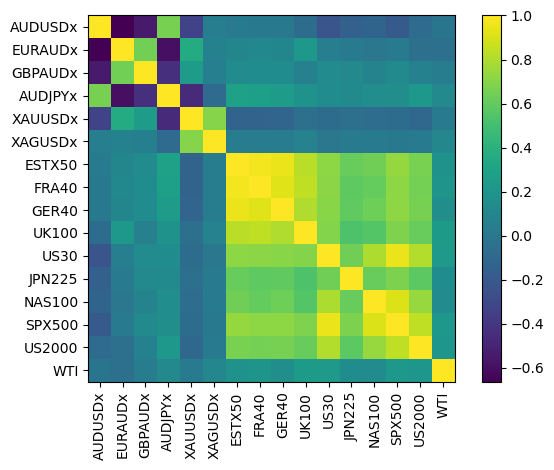

In [77]:
plotting.plot_covariance(co_var, plot_correlation=True, show_tickers=True)

## Generate Effcicent Frontier

In [78]:
mu = expected_returns.mean_historical_return(df, returns_data=False, compounding=True, frequency=252, log_returns=False)
S = risk_models.sample_cov(df, returns_data=False, frequency=252, log_returns=False)


### Max Sharpe Long only

OrderedDict([('XAUUSDx', 0.0045), ('XAGUSDx', 0.0), ('ESTX50', 0.0), ('FRA40', 0.0), ('GER40', 0.0), ('AUS200', 0.0), ('UK100', 0.0), ('US30', 0.0), ('JPN225', 0.08636), ('NAS100', 0.41809), ('SPX500', 0.0), ('US2000', 0.0), ('WTI', 0.0), ('AUDUSDx', 0.0), ('EURAUDx', 0.49106), ('GBPAUDx', 0.0), ('AUDJPYx', 0.0)])
Expected annual return: 9.3%
Annual volatility: 9.5%
Sharpe Ratio: 0.77


<AxesSubplot:xlabel='Weight'>

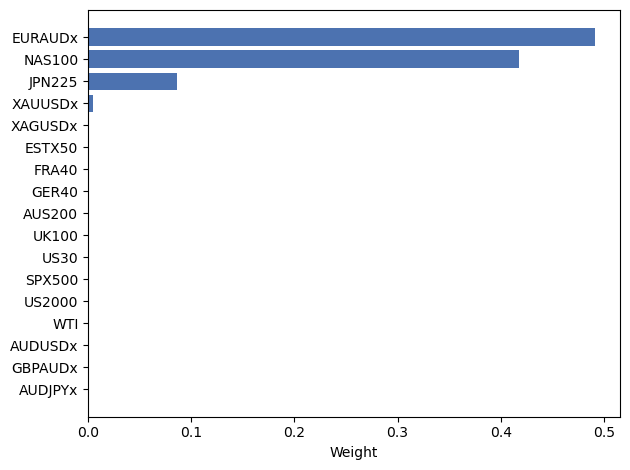

In [79]:
# Optimize the max sharpe ratio
ef = EfficientFrontier(mu,S,verbose=False, weight_bounds=(0,None))
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)
plotting.plot_weights(cleaned_weights, ax=None)

## Max Sharpe Ratio with shorts

OrderedDict([('XAUUSDx', 0.81295), ('XAGUSDx', -0.30256), ('ESTX50', -1.0), ('FRA40', 0.81339), ('GER40', 0.40818), ('AUS200', -0.16281), ('UK100', -0.56428), ('US30', 0.41571), ('JPN225', 0.157), ('NAS100', 0.6924), ('SPX500', -0.00372), ('US2000', -0.31579), ('WTI', 0.00771), ('AUDUSDx', -1.0), ('EURAUDx', 0.62254), ('GBPAUDx', -0.21079), ('AUDJPYx', 0.63007)])
Expected annual return: 25.0%
Annual volatility: 15.7%
Sharpe Ratio: 1.47


<AxesSubplot:xlabel='Weight'>

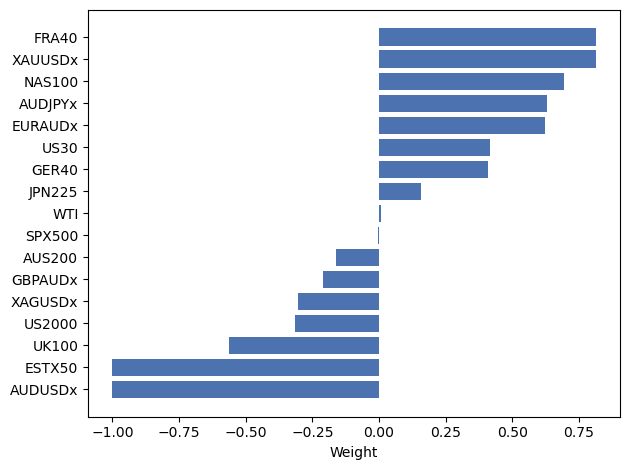

In [80]:
# Optimize the max sharpe ratio
ef = EfficientFrontier(mu,S,verbose=False, weight_bounds=(-1, 1))
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)
plotting.plot_weights(cleaned_weights, ax=None)

## Efficient Cdar with orginal prices eg USD for US indicies


In [81]:
mu = expected_returns.mean_historical_return(df, returns_data=False, compounding=True, frequency=252, log_returns=False)
historical_returns = expected_returns.returns_from_prices(df).dropna()

XAUUSDx  XAGUSDx  ESTX50    FRA40    GER40   AUS200    UK100  US30   JPN225   NAS100   SPX500   US2000      WTI  AUDUSDx  EURAUDx  GBPAUDx  AUDJPYx
0  0.72701 -0.07207    -1.0  0.91852  0.17979 -0.11811 -0.52397   1.0  0.26684  0.55689 -0.62896 -0.16821 -0.05524     -1.0  0.31628 -0.10001  0.70124

Expected annual return: 21.8%
Conditional Drawdown at Risk: 10.00%


<AxesSubplot:xlabel='Weight'>

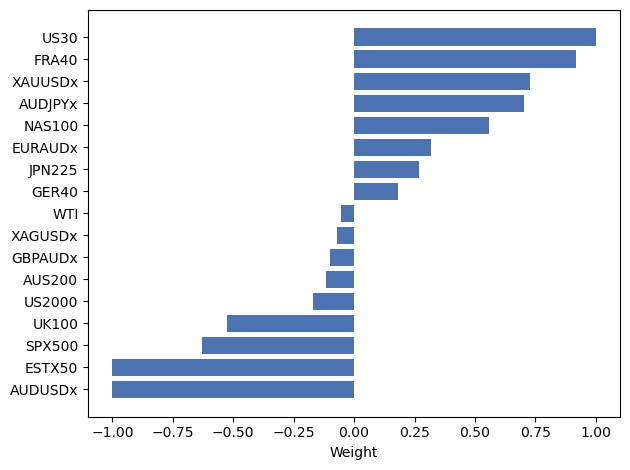

In [82]:
ef_cdar = EfficientCDaR(mu, historical_returns, weight_bounds=(-1,1), beta=0.99, verbose=False)
# ef_cdar.add_objective(objective_functions.L2_reg, gamma=.3)
weights = ef_cdar.efficient_risk(0.10, market_neutral=False)
cleaned_weights = ef_cdar.clean_weights()
cleaned_weights_1 = pd.DataFrame(cleaned_weights, index=[0])
display(cleaned_weights_1)
ef_cdar.portfolio_performance(verbose=True)
plotting.plot_weights(cleaned_weights, ax=None)


### Cdar with AUD returns and FX

In [83]:
mu_aud_fx = expected_returns.mean_historical_return(df_aud_fx, returns_data=False, compounding=True, frequency=252, log_returns=False)
historical_returns_aud_fx = expected_returns.returns_from_prices(df_aud_fx).dropna()

Expected annual return: 39.2%
Conditional Drawdown at Risk: 20.00%


AUDUSDx  EURAUDx  GBPAUDx  AUDJPYx  XAUUSDx  XAGUSDx  ESTX50  FRA40  GER40   UK100   US30  JPN225  NAS100  SPX500  US2000     WTI
0  -1.0000  -0.0871  -1.0000   0.7854   1.0000  -0.0231 -1.0000 1.0000 0.2855 -0.6258 1.0000  0.6545  0.9267 -0.5218 -0.3482 -0.0461

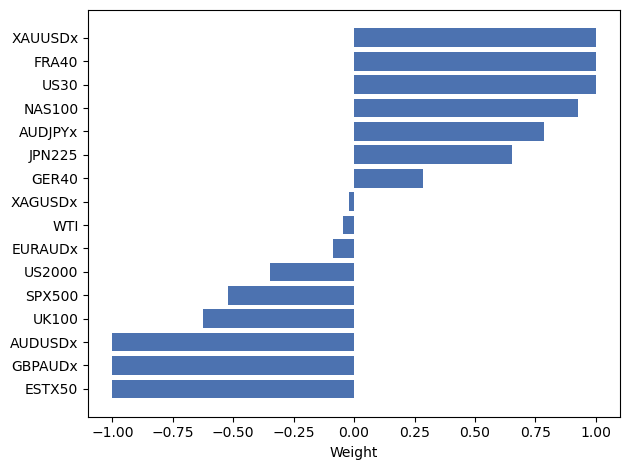

In [113]:
ef_cdar_aud_fx = EfficientCDaR(mu_aud_fx, historical_returns_aud_fx, weight_bounds=(-1,1), beta=0.99, verbose=False)
# ef_cdar.add_objective(objective_functions.L2_reg, gamma=.3)
weights_aud_fx = ef_cdar_aud_fx.efficient_risk(0.20, market_neutral=False)
cleaned_weights_aud_fx = ef_cdar_aud_fx.clean_weights()
ef_cdar_aud_fx.portfolio_performance(verbose=True)
plotting.plot_weights(cleaned_weights_aud_fx, ax=None)

# Create dataframe for weight to be easily displayed
cleaned_weights_2 = pd.DataFrame(cleaned_weights_aud_fx, index=[0])
display(cleaned_weights_2)

# Cdar with AUD returns only

In [114]:
mu_aud = expected_returns.mean_historical_return(df_aud, returns_data=False, compounding=True, frequency=252, log_returns=False)
historical_returns_aud = expected_returns.returns_from_prices(df_aud).dropna()

XAUUSDx  XAGUSDx  ESTX50  FRA40  GER40   UK100   US30  JPN225  NAS100  SPX500  US2000    WTI
0   0.7365  -0.2176 -1.0000 1.0000 0.2328 -0.4878 0.7861  0.1212  0.5757 -0.8452  0.0703 0.0280

Expected annual return: 18.1%
Conditional Drawdown at Risk: 10.00%


<AxesSubplot:xlabel='Weight'>

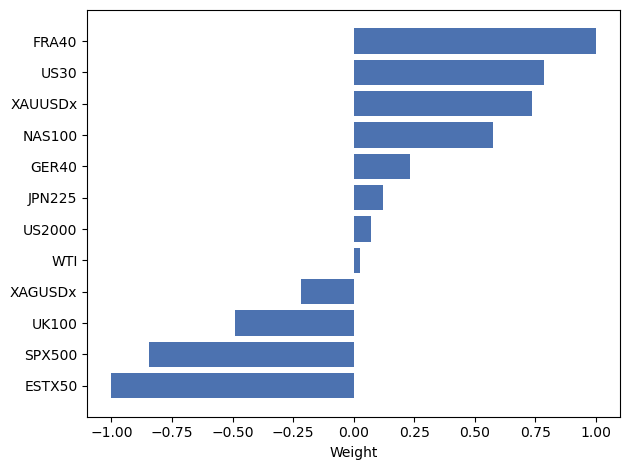

In [115]:
ef_cdar_aud = EfficientCDaR(mu_aud, historical_returns_aud, weight_bounds=(-1,1), beta=0.99, verbose=False)
# ef_cdar.add_objective(objective_functions.L2_reg, gamma=.3)
weights_aud = ef_cdar_aud.efficient_risk(0.10, market_neutral=False)
cleaned_weights_aud = ef_cdar_aud.clean_weights()
cleaned_weights_3 = pd.DataFrame(cleaned_weights_aud, index=[0])
display(cleaned_weights_3)
ef_cdar_aud.portfolio_performance(verbose=True)
plotting.plot_weights(cleaned_weights_aud, ax=None)

## Portfolio calc for AUD_FX optimiser

In [116]:
# Convert the EfficientCDaR result to a DataFrame for AUD returns
cleaned_weights_aud_fx_df = pd.DataFrame(list(cleaned_weights_aud_fx.items()), columns=['Asset', 'Weight'])

# Convert the 'Weight' column to absolute values
cleaned_weights_aud_fx_df['Weight_Absolute'] = cleaned_weights_aud_fx_df['Weight'].abs()

# Calculate the absolute sum of weights
abs_sum_weights_aud_fx = cleaned_weights_aud_fx_df['Weight_Absolute'].sum()

# Establish connection to MetaTrader 5 terminal and retrieve account balance
if not mt5.initialize():
    print("initialize() failed")
    
else:
    # Request account information
    account_info = mt5.account_info()
    if account_info:
        # Store the balance value as a float variable
        total_portfolio_value_aud = float(account_info.balance)
        print(f"Account Balance: {total_portfolio_value_aud}")
    else:
        print("Failed to retrieve account information")

# Calculate the position size for 1 full position
position_size_aud_fx = total_portfolio_value_aud / abs_sum_weights_aud_fx

# Calculate the position size for each asset with no negatives
cleaned_weights_aud_fx_df['Position_Size_AUD'] = cleaned_weights_aud_fx_df['Weight_Absolute'] * position_size_aud_fx

# Replace negative position sizes with zero
cleaned_weights_aud_fx_df['Position_Size_AUD'] = cleaned_weights_aud_fx_df['Position_Size_AUD'].apply(lambda x: max(x, 0))

# Display the absolute values and position sizes for AUD returns
print("Absolute Values and Position Sizes for AUD Returns:")
print(cleaned_weights_aud_fx_df[['Asset', 'Weight_Absolute', 'Position_Size_AUD']])

# Validate that the sum of position sizes equals the total portfolio value
print("\nTotal Portfolio Value for AUD Returns:", cleaned_weights_aud_fx_df['Position_Size_AUD'].sum())

Account Balance: 99667.7
Absolute Values and Position Sizes for AUD Returns:
      Asset  Weight_Absolute  Position_Size_AUD
0   AUDUSDx           1.0000          9672.4189
1   EURAUDx           0.0871           842.4677
2   GBPAUDx           1.0000          9672.4189
3   AUDJPYx           0.7854          7597.2015
4   XAUUSDx           1.0000          9672.4189
5   XAGUSDx           0.0231           223.5296
6    ESTX50           1.0000          9672.4189
7     FRA40           1.0000          9672.4189
8     GER40           0.2855          2761.2822
9     UK100           0.6258          6052.9998
10     US30           1.0000          9672.4189
11   JPN225           0.6545          6330.5015
12   NAS100           0.9267          8963.8175
13   SPX500           0.5218          5047.3584
14   US2000           0.3482          3368.1297
15      WTI           0.0461           445.8985

Total Portfolio Value for AUD Returns: 99667.7


### Lot sizing for assets

In [117]:
# Function to retirve latest price data to be able to calculate the lot size

def get_latest_price(symbol):
    
    # Request symbol data
    symbol_info = mt5.symbol_info(symbol)

    if symbol_info is None:
        print(f"Failed to get symbol information for {symbol}")
        return None
    else:
        if symbol_info.visible:
            # Get the latest tick for the symbol
            tick = mt5.symbol_info_tick(symbol)
            if tick is not None:
                current_price = tick.bid if tick.bid != 0 else tick.last
                # print(f"Current price of {symbol}: {current_price}")
                return current_price
            else:
                print(f"Failed to get the tick for {symbol}")
                return None
        else:
            print(f"{symbol} is not visible in MarketWatch")
            
            return None

# Empty list for latest prices        
prices = []

for i in cleaned_weights_aud_fx_df['Asset']:
    prices.append(get_latest_price(i))

# Add prices to df    
cleaned_weights_aud_fx_df['last_price'] = prices
    
cleaned_weights_aud_fx_df


Asset  Weight  Weight_Absolute  Position_Size_AUD  last_price
0   AUDUSDx -1.0000           1.0000          9672.4189      0.6577
1   EURAUDx -0.0871           0.0871           842.4677      1.6445
2   GBPAUDx -1.0000           1.0000          9672.4189      1.9191
3   AUDJPYx  0.7854           0.7854          7597.2015     96.5600
4   XAUUSDx  1.0000           1.0000          9672.4189   2037.8000
5   XAGUSDx -0.0231           0.0231           223.5296     24.5320
6    ESTX50 -1.0000           1.0000          9672.4189   4424.3300
7     FRA40  1.0000           1.0000          9672.4189   7346.8600
8     GER40  0.2855           0.2855          2761.2822  16451.7700
9     UK100 -0.6258           0.6258          6052.9998   7489.8700
10     US30  1.0000           1.0000          9672.4189  36197.3000
11   JPN225  0.6545           0.6545          6330.5015  32766.0300
12   NAS100  0.9267           0.9267          8963.8175  15784.6600
13   SPX500 -0.5218           0.5218          5047.3584   4564.7600
14   US2000 -0.3482           0.3482          3368.1297   1876.9000
15      WTI -0.0461           0.0461           445.8985     73.7300

In [118]:
# Set index to Asset
cleaned_weights_aud_fx_df = cleaned_weights_aud_fx_df.set_index('Asset')
cleaned_weights_aud_fx_df

Weight  Weight_Absolute  Position_Size_AUD  last_price
Asset                                                          
AUDUSDx -1.0000           1.0000          9672.4189      0.6577
EURAUDx -0.0871           0.0871           842.4677      1.6445
GBPAUDx -1.0000           1.0000          9672.4189      1.9191
AUDJPYx  0.7854           0.7854          7597.2015     96.5600
XAUUSDx  1.0000           1.0000          9672.4189   2037.8000
XAGUSDx -0.0231           0.0231           223.5296     24.5320
ESTX50  -1.0000           1.0000          9672.4189   4424.3300
FRA40    1.0000           1.0000          9672.4189   7346.8600
GER40    0.2855           0.2855          2761.2822  16451.7700
UK100   -0.6258           0.6258          6052.9998   7489.8700
US30     1.0000           1.0000          9672.4189  36197.3000
JPN225   0.6545           0.6545          6330.5015  32766.0300
NAS100   0.9267           0.9267          8963.8175  15784.6600
SPX500  -0.5218           0.5218          5047.3584   4564.7600
US2000  -0.3482           0.3482          3368.1297   1876.9000
WTI     -0.0461           0.0461           445.8985     73.7300

In [119]:
# append currency exchanges to dataframe to allow for conditional statement to update last_price to AUD prices
exchange_currency = [1, 1, 1, 1, 'AUDUSDx', 'AUDUSDx', 'EURAUDx', 'EURAUDx', 'EURAUDx', 'GBPAUDx', 'AUDUSDx', 'AUDJPYx', 'AUDUSDx', 'AUDUSDx', 'AUDUSDx', 'AUDUSDx']
cleaned_weights_aud_fx_df['exchange_currency'] = exchange_currency
cleaned_weights_aud_fx_df

Weight  Weight_Absolute  Position_Size_AUD  last_price exchange_currency
Asset                                                                            
AUDUSDx -1.0000           1.0000          9672.4189      0.6577                 1
EURAUDx -0.0871           0.0871           842.4677      1.6445                 1
GBPAUDx -1.0000           1.0000          9672.4189      1.9191                 1
AUDJPYx  0.7854           0.7854          7597.2015     96.5600                 1
XAUUSDx  1.0000           1.0000          9672.4189   2037.8000           AUDUSDx
XAGUSDx -0.0231           0.0231           223.5296     24.5320           AUDUSDx
ESTX50  -1.0000           1.0000          9672.4189   4424.3300           EURAUDx
FRA40    1.0000           1.0000          9672.4189   7346.8600           EURAUDx
GER40    0.2855           0.2855          2761.2822  16451.7700           EURAUDx
UK100   -0.6258           0.6258          6052.9998   7489.8700           GBPAUDx
US30     1.0000           1.0000          9672.4189  36197.3000           AUDUSDx
JPN225   0.6545           0.6545          6330.5015  32766.0300           AUDJPYx
NAS100   0.9267           0.9267          8963.8175  15784.6600           AUDUSDx
SPX500  -0.5218           0.5218          5047.3584   4564.7600           AUDUSDx
US2000  -0.3482           0.3482          3368.1297   1876.9000           AUDUSDx
WTI     -0.0461           0.0461           445.8985     73.7300           AUDUSDx

### exchange_rates below need manual updating

In [120]:
# Set the display format for float values to show up to 4 decimal places
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))

# formulas for coverting recent MT5 prices in AUD

# Creating a mapping dictionary for exchange rates
exchange_rates = {
    'AUDUSDx': 1.503759398,
    'EURAUDx': 1.63459,  # Replace these values with actual exchange rates
    'GBPAUDx': 1.90435,
    'AUDJPYx': 0.0004837391,
    1:1
    # Add other currencies and their rates if needed
}

# Function to calculate 'last_price_aud' based on exchange rates
def calculate_last_price_aud(row):
    return row['last_price'] * exchange_rates[row['exchange_currency']]

# Applying the function to create the new column 'last_price_aud'
cleaned_weights_aud_fx_df['last_price_aud'] = cleaned_weights_aud_fx_df.apply(calculate_last_price_aud, axis=1)

cleaned_weights_aud_fx_df

Weight  Weight_Absolute  Position_Size_AUD  last_price exchange_currency  last_price_aud
Asset                                                                                            
AUDUSDx -1.0000           1.0000          9672.4189      0.6577                 1          0.6577
EURAUDx -0.0871           0.0871           842.4677      1.6445                 1          1.6445
GBPAUDx -1.0000           1.0000          9672.4189      1.9191                 1          1.9191
AUDJPYx  0.7854           0.7854          7597.2015     96.5600                 1         96.5600
XAUUSDx  1.0000           1.0000          9672.4189   2037.8000           AUDUSDx       3064.3609
XAGUSDx -0.0231           0.0231           223.5296     24.5320           AUDUSDx         36.8902
ESTX50  -1.0000           1.0000          9672.4189   4424.3300           EURAUDx       7231.9656
FRA40    1.0000           1.0000          9672.4189   7346.8600           EURAUDx      12009.1039
GER40    0.2855           0.2855          2761.2822  16451.7700           EURAUDx      26891.8987
UK100   -0.6258           0.6258          6052.9998   7489.8700           GBPAUDx      14263.3339
US30     1.0000           1.0000          9672.4189  36197.3000           AUDUSDx      54432.0301
JPN225   0.6545           0.6545          6330.5015  32766.0300           AUDJPYx         15.8502
NAS100   0.9267           0.9267          8963.8175  15784.6600           AUDUSDx      23736.3308
SPX500  -0.5218           0.5218          5047.3584   4564.7600           AUDUSDx       6864.3007
US2000  -0.3482           0.3482          3368.1297   1876.9000           AUDUSDx       2822.4060
WTI     -0.0461           0.0461           445.8985     73.7300           AUDUSDx        110.8722

In [136]:
# work out a lot_size column for above df

lot_size_rate = {
    'AUDUSDx' : 100000,
    'EURAUDx' : 100000,
    'GBPAUDx' : 100000,
    'AUDJPYx' : 100000, 
    'XAUUSDx' : 100,
    'XAGUSDx' : 1000,
    'ESTX50' : 1, 
    'FRA40' : 1,
    'GER40' : 1, 
    'UK100' : 1,
    'US30' : 1,
    'JPN225' : 100,
    'NAS100' : 1,
    'SPX500' : 10,
    'US2000' : 1,
    'WTI' : 100
}
# Function to calculate mt5 lot size based on ThinkMarkets contract specifications
def calculate_last_price_aud(row):
    asset = row.name  # Accessing the index value (in this case, 'Asset')
    
    if asset in ['AUDUSDx', 'EURAUDx', 'GBPAUDx', 'AUDJPY']:
        return round(row['Position_Size_AUD'] / lot_size_rate[asset],2)
    
    elif asset in ['XAUUSDx', 'XAGUSDx']:
        return round(row['Position_Size_AUD'] / row['last_price_aud'] / lot_size_rate[asset],2)
    
    else:
        return round(row['Position_Size_AUD'] / row['last_price_aud'] / lot_size_rate[asset],1)
    
# Applying the function to create the new column 'lot_size'
cleaned_weights_aud_fx_df['lot_size'] = cleaned_weights_aud_fx_df.apply(calculate_last_price_aud, axis=1)

# Displaying the DataFrame with the newly added 'lot_size' column
cleaned_weights_aud_fx_df


Weight  Weight_Absolute  Position_Size_AUD  last_price exchange_currency  last_price_aud  lot_size
Asset                                                                                                      
AUDUSDx -1.0000           1.0000          9672.4189      0.6577                 1          0.6577    0.1000
EURAUDx -0.0871           0.0871           842.4677      1.6445                 1          1.6445    0.0100
GBPAUDx -1.0000           1.0000          9672.4189      1.9191                 1          1.9191    0.1000
AUDJPYx  0.7854           0.7854          7597.2015     96.5600                 1         96.5600    0.0000
XAUUSDx  1.0000           1.0000          9672.4189   2037.8000           AUDUSDx       3064.3609    0.0300
XAGUSDx -0.0231           0.0231           223.5296     24.5320           AUDUSDx         36.8902    0.0100
ESTX50  -1.0000           1.0000          9672.4189   4424.3300           EURAUDx       7231.9656    1.3000
FRA40    1.0000           1.0000          9672.4189   7346.8600           EURAUDx      12009.1039    0.8000
GER40    0.2855           0.2855          2761.2822  16451.7700           EURAUDx      26891.8987    0.1000
UK100   -0.6258           0.6258          6052.9998   7489.8700           GBPAUDx      14263.3339    0.4000
US30     1.0000           1.0000          9672.4189  36197.3000           AUDUSDx      54432.0301    0.2000
JPN225   0.6545           0.6545          6330.5015  32766.0300           AUDJPYx         15.8502    4.0000
NAS100   0.9267           0.9267          8963.8175  15784.6600           AUDUSDx      23736.3308    0.4000
SPX500  -0.5218           0.5218          5047.3584   4564.7600           AUDUSDx       6864.3007    0.1000
US2000  -0.3482           0.3482          3368.1297   1876.9000           AUDUSDx       2822.4060    1.2000
WTI     -0.0461           0.0461           445.8985     73.7300           AUDUSDx        110.8722    0.0000

## Buy assets

In [137]:
# Retrieve account information
account = mt5.account_info()
if account:
    balance = account.balance
    equity = account.equity
    free_margin = account.margin_free
    print(f"Balance: {balance}")
    print(f"Equity: {equity}")
    print(f"Free Margin: {free_margin}")
else:
    print("Failed to retrieve account information")

Balance: 99619.76
Equity: 99619.76
Free Margin: 99619.76


In [138]:
# Metatrader functions to execute long or short market order positions

def short_order(symbol, lot_size):
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": lot_size,
        "type": mt5.ORDER_TYPE_SELL,
        "comment": "Cdar short",
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_FOK}
    print('A short was executed')
    mt5.order_send(request)

def long_order(symbol, lot_size):
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": lot_size,
        "type": mt5.ORDER_TYPE_BUY,
        "comment": "Cdar long",
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_FOK}
    print('A long was executed')
    mt5.order_send(request)

# long_order('XAUUSDx', 1.0) 
# short_order('XAUUSDx', 1.0)

In [140]:
def execution_long_short(row):
    asset = row.name 
    
    if row['Weight'] < 0:
        short_order(asset, row['lot_size'])
    else:
        long_order(asset, row['lot_size'])
        
cleaned_weights_aud_fx_df.apply(execution_long_short, axis=1) 

A short was executed
A short was executed
A short was executed
A long was executed
A long was executed
A short was executed
A short was executed
A long was executed
A long was executed
A short was executed
A long was executed
A long was executed
A long was executed
A short was executed
A short was executed
A short was executed


Asset
AUDUSDx    None
EURAUDx    None
GBPAUDx    None
AUDJPYx    None
XAUUSDx    None
XAGUSDx    None
ESTX50     None
FRA40      None
GER40      None
UK100      None
US30       None
JPN225     None
NAS100     None
SPX500     None
US2000     None
WTI        None
dtype: object

In [ ]:
mt5.shutdown()